# Исследовательская тетрадка по прогнозу пополнений банкоматов бустингом

In [42]:
%load_ext autoreload

import os
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt
from plotly import express as px

from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone
from lightgbm import LGBMRegressor, LGBMClassifier

from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    f1_score,
    classification_report
)

from bank_schedule import data as bs_data
from bank_schedule import cluster as bs_cluster
from bank_schedule import helpers

from bank_schedule.constants import (
    CENTER_LAT,
    CENTER_LON,
    RAW_DATA_FOLDER,
    INTERIM_DATA_FOLDER
)

from bank_schedule.forecast import SimpleRollingForecast

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Читаем данные

In [2]:
loader = bs_data.Data(RAW_DATA_FOLDER)

in_df = loader.get_money_in()
start_df = loader.get_money_start()
geo_df = loader.get_geo_TIDS()

display(in_df.head())
print(in_df.info())

display(start_df.head())
print(start_df.info())

display(geo_df.head())
print(geo_df.info())

,date,TID,money_in
0,2022-09-01,406136,90000
1,2022-09-01,406139,103000
2,2022-09-01,406145,143000
3,2022-09-01,406148,50000
4,2022-09-01,406180,96000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148330 entries, 0 to 148329
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      148330 non-null  datetime64[ns]
 1   TID       148330 non-null  int64         
 2   money_in  148330 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 3.4 MB
None


,TID,money
0,406136,160000
1,406139,387000
2,406145,287000
3,406148,355000
4,406180,597000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   TID     1630 non-null   int64
 1   money   1630 non-null   int64
dtypes: int64(2)
memory usage: 25.6 KB
None


,TID,longitude,latitude
0,692835,37.646257,55.742062
1,698656,37.666136,55.731231
2,686168,37.675027,55.727031
3,679671,37.669706,55.706824
4,682180,37.596399,55.711151


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TID        1630 non-null   int64  
 1   longitude  1630 non-null   float64
 2   latitude   1630 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 38.3 KB
None


In [3]:
print('Всего банкоматов:', in_df['TID'].unique().shape[0])

Всего банкоматов: 1630


In [4]:
# label ничего не докидывает
# data = in_df.merge(bs_cluster.clusterize_atm(loader, n_clusters=100))

data = in_df.merge(start_df).merge(geo_df)
data = data.join(helpers.extract_features_from_date(data['date']))
display(data)

,date,TID,money_in,money,longitude,latitude,day,weekday
0,2022-09-01,406136,90000,160000,38.034618,55.641764,1,3
1,2022-09-02,406136,105000,160000,38.034618,55.641764,2,4
2,2022-09-03,406136,99000,160000,38.034618,55.641764,3,5
3,2022-09-04,406136,107000,160000,38.034618,55.641764,4,6
4,2022-09-05,406136,110000,160000,38.034618,55.641764,5,0
...,...,...,...,...,...,...,...,...
148325,2022-11-26,699664,0,333000,37.719595,55.785676,26,5
148326,2022-11-27,699664,44000,333000,37.719595,55.785676,27,6
148327,2022-11-28,699664,0,333000,37.719595,55.785676,28,0
148328,2022-11-29,699664,55000,333000,37.719595,55.785676,29,1


In [5]:
features_df = helpers.create_features(in_df)
targets_df = helpers.create_targets(in_df)

100%|██████████| 1630/1630 [00:19<00:00, 82.59it/s]


In [6]:
display(features_df)
display(targets_df)

,date,TID,yesterday_income_growth,yesterday_growth_of_income_growth,income_1_day_before,income_2_day_before,income_3_day_before,income_4_day_before,income_5_day_before,income_6_day_before,...,income_25_day_before,income_26_day_before,income_27_day_before,income_28_day_before,income_29_day_before,income_30_day_before,mean_income_all,mean_income_last_30_days,mean_income_last_7_days,mean_income_last_3_days
0,2022-09-01,406136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,92989.010989,NaN,NaN,NaN
1,2022-09-02,406136,NaN,NaN,90000.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,92989.010989,NaN,NaN,NaN
2,2022-09-03,406136,15000.0,NaN,105000.0,90000.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,92989.010989,NaN,NaN,NaN
3,2022-09-04,406136,-6000.0,NaN,99000.0,105000.0,90000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,92989.010989,NaN,NaN,98000.000000
4,2022-09-05,406136,8000.0,-21000.0,107000.0,99000.0,105000.0,90000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,92989.010989,NaN,NaN,103666.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148325,2022-11-26,699664,-2000.0,-7000.0,33000.0,35000.0,30000.0,18000.0,18000.0,29000.0,...,18000.0,0.0,40000.0,0.0,36000.0,0.0,22472.527473,23533.333333,31857.142857,32666.666667
148326,2022-11-27,699664,-33000.0,-7000.0,0.0,33000.0,35000.0,30000.0,18000.0,18000.0,...,0.0,18000.0,0.0,40000.0,0.0,36000.0,22472.527473,23533.333333,23285.714286,22666.666667
148327,2022-11-28,699664,44000.0,-31000.0,44000.0,0.0,33000.0,35000.0,30000.0,18000.0,...,58000.0,0.0,18000.0,0.0,40000.0,0.0,22472.527473,23800.000000,25428.571429,25666.666667
148328,2022-11-29,699664,-44000.0,77000.0,0.0,44000.0,0.0,33000.0,35000.0,30000.0,...,46000.0,58000.0,0.0,18000.0,0.0,40000.0,22472.527473,23800.000000,22857.142857,14666.666667


,date,TID,target_income_1_day_after,target_income_2_day_after,target_income_3_day_after,target_income_4_day_after,target_income_5_day_after,target_income_6_day_after,target_income_7_day_after,target_income_8_day_after,...,target_income_21_day_after,target_income_22_day_after,target_income_23_day_after,target_income_24_day_after,target_income_25_day_after,target_income_26_day_after,target_income_27_day_after,target_income_28_day_after,target_income_29_day_after,target_income_30_day_after
0,2022-09-01,406136,105000.0,99000.0,107000.0,110000.0,60000.0,75000.0,89000.0,95000.0,...,55000.0,125000.0,110000.0,115000.0,100000.0,75000.0,99000.0,100000.0,0.0,106000.0
1,2022-09-02,406136,99000.0,107000.0,110000.0,60000.0,75000.0,89000.0,95000.0,116000.0,...,125000.0,110000.0,115000.0,100000.0,75000.0,99000.0,100000.0,0.0,106000.0,120000.0
2,2022-09-03,406136,107000.0,110000.0,60000.0,75000.0,89000.0,95000.0,116000.0,85000.0,...,110000.0,115000.0,100000.0,75000.0,99000.0,100000.0,0.0,106000.0,120000.0,85000.0
3,2022-09-04,406136,110000.0,60000.0,75000.0,89000.0,95000.0,116000.0,85000.0,110000.0,...,115000.0,100000.0,75000.0,99000.0,100000.0,0.0,106000.0,120000.0,85000.0,102000.0
4,2022-09-05,406136,60000.0,75000.0,89000.0,95000.0,116000.0,85000.0,110000.0,84000.0,...,100000.0,75000.0,99000.0,100000.0,0.0,106000.0,120000.0,85000.0,102000.0,94000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148325,2022-11-26,699664,44000.0,0.0,55000.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148326,2022-11-27,699664,0.0,55000.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148327,2022-11-28,699664,55000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148328,2022-11-29,699664,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
train_data = data.merge(features_df).merge(targets_df)
train_data.sort_values(by=['date', 'TID'], inplace=True)
train_data.set_index('date', inplace=True)
display(train_data)

,TID,money_in,money,longitude,latitude,day,weekday,yesterday_income_growth,yesterday_growth_of_income_growth,income_1_day_before,...,target_income_21_day_after,target_income_22_day_after,target_income_23_day_after,target_income_24_day_after,target_income_25_day_after,target_income_26_day_after,target_income_27_day_after,target_income_28_day_after,target_income_29_day_after,target_income_30_day_after
date,,,,,,,,,,,,,,,,,,,,,
2022-09-01,406136,90000,160000,38.034618,55.641764,1,3,NaN,NaN,NaN,...,55000.0,125000.0,110000.0,115000.0,100000.0,75000.0,99000.0,100000.0,0.0,106000.0
2022-09-01,406139,103000,387000,37.932528,55.701643,1,3,NaN,NaN,NaN,...,143000.0,171000.0,160000.0,149000.0,141000.0,98000.0,153000.0,121000.0,199000.0,187000.0
2022-09-01,406145,143000,287000,37.609267,55.596382,1,3,NaN,NaN,NaN,...,129000.0,158000.0,119000.0,113000.0,122000.0,135000.0,116000.0,137000.0,0.0,0.0
2022-09-01,406148,50000,355000,37.477741,55.892675,1,3,NaN,NaN,NaN,...,85000.0,75000.0,55000.0,67000.0,75000.0,75000.0,65000.0,62000.0,76000.0,70000.0
2022-09-01,406180,96000,597000,37.656786,55.707940,1,3,NaN,NaN,NaN,...,67000.0,87000.0,80000.0,72000.0,76000.0,70000.0,75000.0,75000.0,96000.0,75000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,699578,120000,47000,37.575648,55.733194,30,2,-2000.0,55000.0,43000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-30,699579,94000,236000,37.579691,55.734600,30,2,-41000.0,104000.0,63000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-30,699629,50000,67000,37.312186,55.550391,30,2,15000.0,-6000.0,62000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
def extract_dayofyear_series(train_data: pd.DataFrame) -> pd.Series:
    """Вытаскивает из трейна день года
    Нужен для разбиения на трейн-валидацию-тест

    Args:
        train_data (pd.DataFrame): _description_

    Returns:
        pd.Series: _description_
    """
    dayofyear = pd.Series(data=train_data.index,
                          index=train_data.index)

    dayofyear = dayofyear.dt.dayofyear
    return dayofyear


def filter_train_by_needed_days(train_data: pd.DataFrame,
                                needed_days: list) -> pd.DataFrame:
    """Фильтрует трейн по нужным дням года
    Нужен для разбиения на трейн-валидацию-тест

    Args:
        train_data (pd.DataFrame): _description_
        needed_days (list): _description_

    Returns:
        pd.DataFrame: _description_
    """
    train_data = train_data.copy()
    dayofyear = extract_dayofyear_series(train_data)
    return train_data[dayofyear.isin(needed_days)]

In [9]:
dayofyear = extract_dayofyear_series(train_data)

unique_dayofyear = dayofyear.unique()
unique_dayofyear.sort()

private_days = unique_dayofyear[-30:]
public_days = unique_dayofyear[:-30]

In [84]:
forecast_horizon = 1
min_train_size = 7
gap = 7

tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=30, test_size=1)

train_val_test_days = []

for i, (train_index, test_index) in enumerate(tscv.split(public_days[:-gap])):
    train_days = public_days[train_index]
    val_day = public_days[test_index][-1]

    if forecast_horizon > 1:
        train_days = public_days[train_index][:-forecast_horizon + 1]
    if len(train_days) >= min_train_size:
        train_val_test_days.append((train_days, [val_day], [val_day + gap]))


features_cols = [col for col in train_data.columns if 'target' not in col]
features_cols = [col for col in features_cols if 'TID' not in col]
needed_target = f'target_income_{forecast_horizon}_day_after'
true_target = 'money_in'

mae_list = []
simple_mae_list = []

mape_list = []
simple_mape_list = []

f1_list = []

for train_days, val_days, test_days in train_val_test_days:

    print(train_days, val_days, test_days)

    if val_days[0] - train_days[-1] != forecast_horizon:
        raise ValueError('Ошибка в расчете дней для обучения')

    X_train = filter_train_by_needed_days(train_data, train_days)
    X_val = filter_train_by_needed_days(train_data, val_days)
    X_test = filter_train_by_needed_days(train_data, test_days)

    y_train_simple = X_train[['TID', 'money_in']]
    y_test_simple = X_test[['TID', 'money_in']]

    simple_true = []
    simple_pred = []

    for tid in y_train_simple['TID'].unique():
        __train = y_train_simple[y_train_simple['TID'] == tid]['money_in']
        simple_model = SimpleRollingForecast(window=10)
        simple_model.fit(__train)
        pred = simple_model.predict(forecast_horizon).values[-1]
        true = y_test_simple[y_test_simple['TID'] == tid]['money_in'].values[0]
        simple_true.append(true)
        simple_pred.append(pred)

    simple_true = np.asarray(simple_true)
    simple_pred = np.asarray(simple_pred)

    simple_mae_list.append(mean_absolute_error(simple_true, simple_pred))
    simple_mape_list.append(mean_absolute_percentage_error(simple_true[simple_true != 0],
                                                           simple_pred[simple_true != 0]))

    X_train, y_train = X_train[features_cols], X_train[needed_target]
    X_val, y_val = X_val[features_cols], X_val[true_target]
    X_test, y_test = X_test[features_cols], X_test[true_target]


    lgb_pars = dict(
        n_estimators=1000,
        num_leaves=31,
        bagging_fraction=.7,
        feature_fraction=.7,
        random_state=27,
        early_stopping_round=5
    )

    class_lgb_pars = dict(
        n_estimators=1000,
        num_leaves=31,
        bagging_fraction=.7,
        feature_fraction=.7,
        random_state=27,
        early_stopping_round=5,
        class_weight='balanced'
    )

    model = LGBMRegressor(**lgb_pars)
    class_model = LGBMClassifier(**class_lgb_pars)

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='mae'
    )

    class_model.fit(
        X_train, y_train==0,
        eval_set=[(X_val, y_val==0)],
        eval_metric='mae'
    )

    lgb_pars['n_estimators'] = model.best_iteration_
    lgb_pars['early_stopping_round'] = None

    class_lgb_pars['n_estimators'] = class_model.best_iteration_
    class_lgb_pars['early_stopping_round'] = None

    extended_train_days = list(range(train_days[0],
                                     train_days[-1] + gap + 1,
                                     1))

    print(extended_train_days, test_days)

    if test_days[0] - extended_train_days[-1]  != forecast_horizon:
        raise ValueError('Ошибка в расчете дней для обучения')

    X_train = filter_train_by_needed_days(train_data,
                                          extended_train_days)

    X_train, y_train = X_train[features_cols], X_train[needed_target]

    model = LGBMRegressor(**lgb_pars)
    class_model = LGBMClassifier(**class_lgb_pars)

    model.fit(X_train, y_train)
    class_model.fit(X_train, y_train==0)

    y_pred = model.predict(X_test)
    y_pred_class = class_model.predict(X_test)

    mae_list.append(mean_absolute_error(y_test, y_pred))
    mape_list.append(mean_absolute_percentage_error(y_test[y_test != 0],
                                                    y_pred[y_test != 0]))

    f1_list.append(f1_score(y_test==0, y_pred_class))

[244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 266 267] [268] [275]
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's l1: 26660.5	valid_0's l2: 1.50888e+09
[2]	valid_0's l1: 24630.2	valid_0's l2: 1.29053e+09
[3]	valid_0's l1: 22880	valid_0's l2: 1.11811e+09
[4]	valid_0's l1: 21409.2	valid_0's l2: 9.95456e+08
[5]	valid_0's l1: 20111.1	valid_0's l2: 8.97609e+08
[6]	valid_0's l1: 18900.3	valid_0's l2: 8.13115e+08
[7]	valid_0's l1: 17800.9	valid_0's l2: 7.43037e+08
[8]	valid_0's l1: 17002.5	valid_0's l2: 7.0458e+08
[9]	valid_0's l1: 16219.7	valid_0's l2: 6.63687e+08
[10]	valid_0's l1: 15617.5	valid_0's l2: 6.35627e+08
[11]	valid_0's l1: 15116	valid_0's l2: 6.22964e+08
[12]	valid_0's l1: 14715.3	valid_0's l2: 6.1614e+08
[13]	valid_0's l1: 14389	va

In [85]:
impotances_df = pd.DataFrame(data=model.feature_importances_, index=X_train.columns, columns=['importance'])
display(impotances_df)

class_impotances_df = pd.DataFrame(data=class_model.feature_importances_, index=X_train.columns, columns=['importance'])
display(class_impotances_df)

,importance
money_in,89
money,6
longitude,4
latitude,23
day,1
weekday,7
yesterday_income_growth,2
yesterday_growth_of_income_growth,11
income_1_day_before,18
income_2_day_before,7


,importance
money_in,395
money,243
longitude,320
latitude,336
day,142
weekday,96
yesterday_income_growth,264
yesterday_growth_of_income_growth,281
income_1_day_before,281
income_2_day_before,231


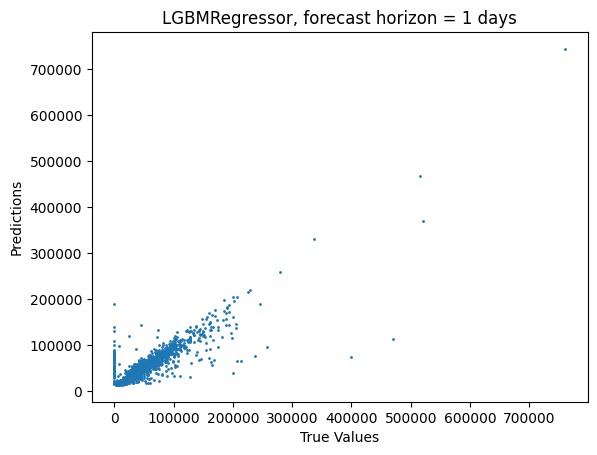

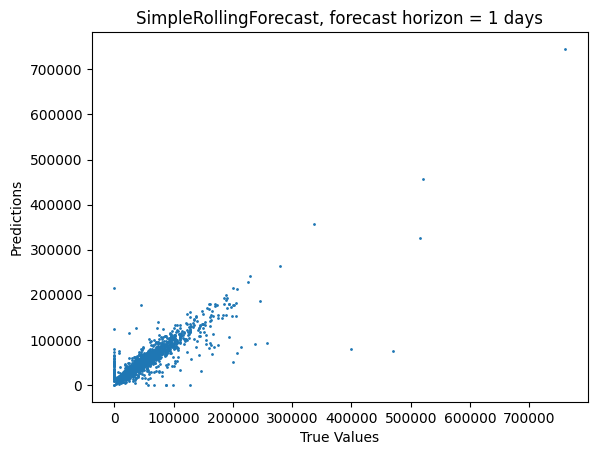

f1 LGBMClassifier: 0.46
Mean Absolute Error LGBMRegressor: 12765.72
Mean Absolute Percentage Error LGBMRegressor: 0.27
Correlations between true and predicted LGBMRegressor: 0.86

Mean Absolute Error SimpleRollingForecast: 12223.28
Mean Absolute Percentage Error SimpleRollingForecast: 0.24
Correlations between true and predicted SimpleRollingForecast: 0.86


In [86]:
y_pred = pd.Series(y_pred, index=y_test.index)
plt.scatter(x=y_test, y=y_pred, s=1)
plt.title(f'LGBMRegressor, forecast horizon = {forecast_horizon} days')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

plt.scatter(x=simple_true, y=simple_pred, s=1)
plt.title(f'SimpleRollingForecast, forecast horizon = {forecast_horizon} days')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

lgbm_corr = np.corrcoef(y_test, y_pred)[0, 1]
lgbm_corr = round(lgbm_corr, 2)

simple_corr = np.corrcoef(simple_true, simple_pred)[0, 1]
simple_corr = round(simple_corr, 2)

print(f'f1 LGBMClassifier: {np.mean(f1_list).round(2)}')
print(f'Mean Absolute Error LGBMRegressor: {np.mean(mae_list).round(2)}')
print(f'Mean Absolute Percentage Error LGBMRegressor: {np.mean(mape_list).round(2)}')
print(f'Correlations between true and predicted LGBMRegressor: {lgbm_corr}')

print(f'\nMean Absolute Error SimpleRollingForecast: {np.mean(simple_mae_list).round(2)}')
print(f'Mean Absolute Percentage Error SimpleRollingForecast: {np.mean(simple_mape_list).round(2)}')
print(f'Correlations between true and predicted SimpleRollingForecast: {simple_corr}')

In [87]:
class_proba = class_model.predict_proba(X_test).T[1]

In [88]:
from sklearn.metrics import classification_report
threshold = .9
print(classification_report(y_test==0, class_proba>threshold, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.97      0.98      0.97      1565
    positive       0.29      0.15      0.20        65

    accuracy                           0.95      1630
   macro avg       0.63      0.57      0.59      1630
weighted avg       0.94      0.95      0.94      1630



In [89]:
possible_zero = class_proba > threshold
y_pred_corrected = y_pred.copy()
y_pred_corrected[possible_zero] = 0

mean_absolute_error(y_test, y_pred_corrected), mean_absolute_error(y_test, y_pred)

(12541.938169894689, 12433.613699276257)

In [90]:
# tid_crosscorr_df = helpers.get_tid_income_cross_correlations()

In [91]:
# needed_tid = 605381
# cond1 = tid_crosscorr_df['TID'] == needed_tid
# cond2 = tid_crosscorr_df['pearson_coef'] > .75
# all_needed_tids = tid_crosscorr_df.loc[cond1 & cond2, 'other_TID'].to_list()
# all_needed_tids.append(needed_tid)

# needed_df = geo_df[geo_df['TID'].isin(all_needed_tids)].copy()
# needed_df['is_root'] = (needed_df['TID'] == needed_tid).astype(str)
# display(needed_df)

# fig = px.line(in_df[in_df['TID'].isin(all_needed_tids)],
#               x='date',
#               y='money_in',
#               color='TID',
#               title='Money in')

# fig.show()

# fig = px.scatter_mapbox(needed_df,
#                         lat='latitude',
#                         lon='longitude',
#                         color='is_root',
#                         hover_name=needed_df['TID'],
#                         center=dict(lat=CENTER_LAT, lon=CENTER_LON),
#                         height=800,
#                         width=800,
#                         opacity=.9,
#                         mapbox_style="carto-positron")

# fig.show()